In [1]:
from vulnerable_populations.pipeline import Granularity

granularity = Granularity.COUNTY_LEVEL

In [2]:
csbh_data = catalog.load(f"int_csbh_{granularity.value}_data")
csbh_data

2020-06-14 10:06:55,575 - kedro.io.data_catalog - INFO - Loading data from `int_csbh_county_level_data` (ParquetDataSet)...


,Insurance Type (Relevant for Clinical Data from Claims Only),FIPS County Code,County,State,State Code,Population,Deaths from COVID-19,Cases of COVID-19,Deaths from Covid 19 Per 100K Population,Cases of Covid 19 Per 100K Population,...,Children on Free or Reduced Lunch,American Indian or Alaska Native,Asian,Black or African American,Hispanic,Native Hawaiian or Other Pacific Islander,Non-Hispanic White,Other race,2 or more races,Racial / Ethnic Minority
0,All,49055,Wayne,Utah,UT,2690.0,0.0,0.0,0.0,0.0,...,0.500,0.003,0.005,0.003,0.059,0.013,0.912,0.000,0.006,0.083
1,All,21091,Hancock,Kentucky,KY,8758.0,0.0,7.0,0.0,79.0,...,0.510,0.001,0.007,0.009,0.015,0.000,0.956,0.000,0.011,0.033
2,All,27077,Lake of the Woods,Minnesota,MN,3758.0,0.0,0.0,0.0,0.0,...,0.532,0.003,0.008,0.000,0.017,0.000,0.930,0.000,0.041,0.028
3,All,19129,Mills,Iowa,IA,15063.0,0.0,22.0,0.0,146.0,...,0.347,0.007,0.003,0.009,0.030,0.000,0.943,0.000,0.008,0.049
4,All,49033,Rich,Utah,UT,2464.0,0.0,0.0,0.0,0.0,...,0.396,0.000,0.000,0.000,0.109,0.000,0.865,0.026,0.000,0.109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6275,Medicare FFS,37033,Caswell,North Carolina,NC,22698.0,1.0,101.0,4.0,444.0,...,0.809,0.002,0.007,0.329,0.038,0.002,0.612,0.000,0.010,0.378
6276,Medicare FFS,51053,Dinwiddie,Virginia,VA,28529.0,0.0,101.0,0.0,354.0,...,0.521,0.000,0.007,0.320,0.034,0.001,0.618,0.005,0.014,0.362
6277,Medicare FFS,51137,Orange,Virginia,VA,36644.0,2.0,119.0,5.0,324.0,...,0.420,0.003,0.010,0.124,0.048,0.000,0.785,0.003,0.029,0.184
6278,Medicare FFS,46113,Shannon,South Dakota,SD,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [3]:
master = csbh_data.loc[csbh_data["Insurance Type (Relevant for Clinical Data from Claims Only)"] == "All"].dropna()
master

,Insurance Type (Relevant for Clinical Data from Claims Only),FIPS County Code,County,State,State Code,Population,Deaths from COVID-19,Cases of COVID-19,Deaths from Covid 19 Per 100K Population,Cases of Covid 19 Per 100K Population,...,Children on Free or Reduced Lunch,American Indian or Alaska Native,Asian,Black or African American,Hispanic,Native Hawaiian or Other Pacific Islander,Non-Hispanic White,Other race,2 or more races,Racial / Ethnic Minority
0,All,49055,Wayne,Utah,UT,2690.0,0.0,0.0,0.0,0.0,...,0.500,0.003,0.005,0.003,0.059,0.013,0.912,0.000,0.006,0.083
1,All,21091,Hancock,Kentucky,KY,8758.0,0.0,7.0,0.0,79.0,...,0.510,0.001,0.007,0.009,0.015,0.000,0.956,0.000,0.011,0.033
2,All,27077,Lake of the Woods,Minnesota,MN,3758.0,0.0,0.0,0.0,0.0,...,0.532,0.003,0.008,0.000,0.017,0.000,0.930,0.000,0.041,0.028
3,All,19129,Mills,Iowa,IA,15063.0,0.0,22.0,0.0,146.0,...,0.347,0.007,0.003,0.009,0.030,0.000,0.943,0.000,0.008,0.049
4,All,49033,Rich,Utah,UT,2464.0,0.0,0.0,0.0,0.0,...,0.396,0.000,0.000,0.000,0.109,0.000,0.865,0.026,0.000,0.109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,All,22007,Assumption Parish,Louisiana,LA,22300.0,14.0,258.0,62.0,1156.0,...,0.681,0.004,0.002,0.299,0.029,0.000,0.656,0.000,0.011,0.333
3134,All,27093,Meeker,Minnesota,MN,23141.0,1.0,50.0,4.0,216.0,...,0.370,0.001,0.003,0.006,0.038,0.000,0.942,0.001,0.010,0.048
3135,All,37033,Caswell,North Carolina,NC,22698.0,1.0,101.0,4.0,444.0,...,0.809,0.002,0.007,0.329,0.038,0.002,0.612,0.000,0.010,0.378
3136,All,51053,Dinwiddie,Virginia,VA,28529.0,0.0,101.0,0.0,354.0,...,0.521,0.000,0.007,0.320,0.034,0.001,0.618,0.005,0.014,0.362


In [4]:
master.isna().sum(axis=1).value_counts(dropna=False)

0    3138
dtype: int64

In [5]:
from enum import Enum


class Target(Enum):
    DEATHS = "Deaths from Covid 19 Per 100K Population"
    CASES = "Cases of Covid 19 Per 100K Population"

In [6]:
# X = master.loc[
#     :,
#     [
#         "Population Density",
#         "American Indian or Alaska Native",
#         "Asian",
#         "Black or African American",
#         "Hispanic",
#         "Native Hawaiian or Other Pacific Islander",
#         "Non-Hispanic White",
#     ]
# ]
X = master.loc[:, "Age 60+":]
y = master[Target.CASES.value]

In [7]:
(y > 0).mean(skipna=False)

0.9445506692160612

In [8]:
(csbh_data
 .loc[csbh_data["Insurance Type (Relevant for Clinical Data from Claims Only)"] == "All"]
 ["Deaths from Covid 19 Per 100K Population"] > 0).sum()

1808

In [9]:
import pandas as pd

with pd.option_context("display.max_rows", None):
    display(csbh_data.dtypes)

Insurance Type (Relevant for Clinical Data from Claims Only)     object
FIPS County Code                                                  int64
County                                                           object
State                                                            object
State Code                                                       object
Population                                                      float64
Deaths from COVID-19                                            float64
Cases of COVID-19                                               float64
Deaths from Covid 19 Per 100K Population                        float64
Cases of Covid 19 Per 100K Population                           float64
Age 60+                                                         float64
Age 70+                                                         float64
Age 80+                                                         float64
Asthma                                                          

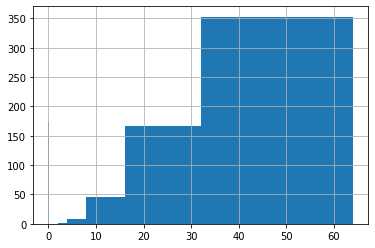

In [10]:
y.hist(bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 2, 4, 8, 16, 32, 64])

In [11]:
len(y)

3138

In [12]:
len(y.to_numpy().nonzero()[0])

2964

In [13]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc.  Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing


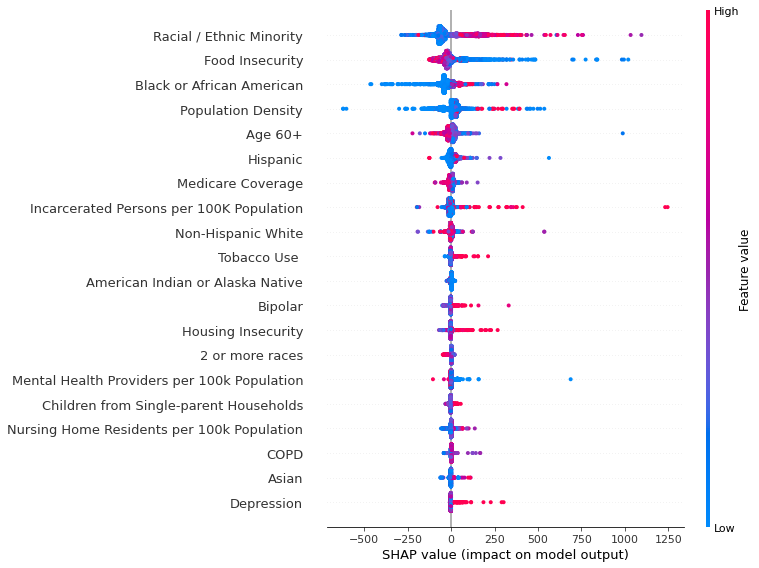

In [14]:
shap.summary_plot(shap_values, X)

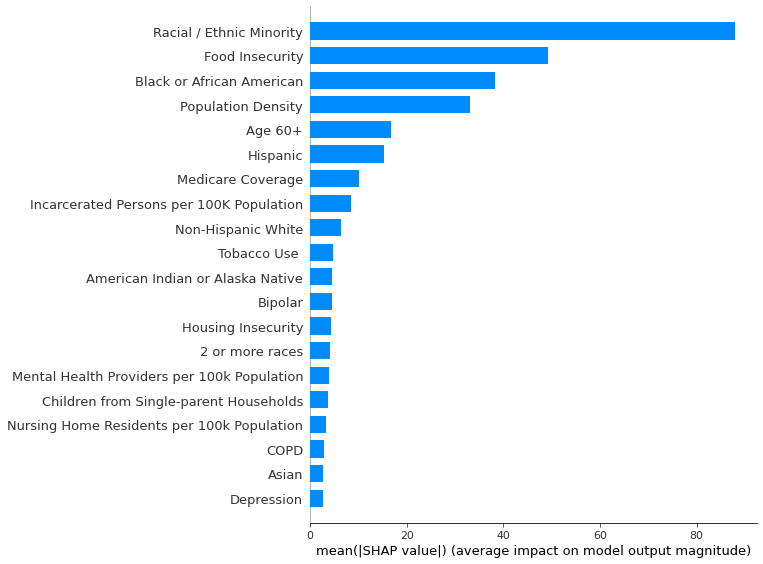

In [15]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [16]:
X

,Age 60+,Age 70+,Age 80+,Asthma,Cancer,Chronic Kidney Disease,Chronic Liver Disease,COPD,Coronary Heart Disease,Diabetes,...,Children on Free or Reduced Lunch,American Indian or Alaska Native,Asian,Black or African American,Hispanic,Native Hawaiian or Other Pacific Islander,Non-Hispanic White,Other race,2 or more races,Racial / Ethnic Minority
0,0.282,0.138,0.036,0.026,0.026,0.018,0.009,0.018,0.019,0.029,...,0.500,0.003,0.005,0.003,0.059,0.013,0.912,0.000,0.006,0.083
1,0.229,0.111,0.032,0.038,0.019,0.044,0.011,0.035,0.065,0.084,...,0.510,0.001,0.007,0.009,0.015,0.000,0.956,0.000,0.011,0.033
2,0.320,0.142,0.053,0.045,0.019,0.038,0.006,0.045,0.064,0.064,...,0.532,0.003,0.008,0.000,0.017,0.000,0.930,0.000,0.041,0.028
3,0.248,0.108,0.043,0.046,0.028,0.056,0.009,0.041,0.075,0.088,...,0.347,0.007,0.003,0.009,0.030,0.000,0.943,0.000,0.008,0.049
4,0.237,0.125,0.040,0.046,0.009,0.028,0.009,0.019,0.019,0.037,...,0.396,0.000,0.000,0.000,0.109,0.000,0.865,0.026,0.000,0.109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,0.235,0.108,0.031,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.681,0.004,0.002,0.299,0.029,0.000,0.656,0.000,0.011,0.333
3134,0.267,0.132,0.048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.370,0.001,0.003,0.006,0.038,0.000,0.942,0.001,0.010,0.048
3135,0.276,0.138,0.049,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.809,0.002,0.007,0.329,0.038,0.002,0.612,0.000,0.010,0.378
3136,0.229,0.104,0.035,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.521,0.000,0.007,0.320,0.034,0.001,0.618,0.005,0.014,0.362


In [17]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
model2 = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer2 = shap.TreeExplainer(model2, data=X)
shap_values2 = explainer2.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer2.expected_value, shap_values2[0,:], X.iloc[0,:])

Passing 3138 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc.  Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc.  Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is 

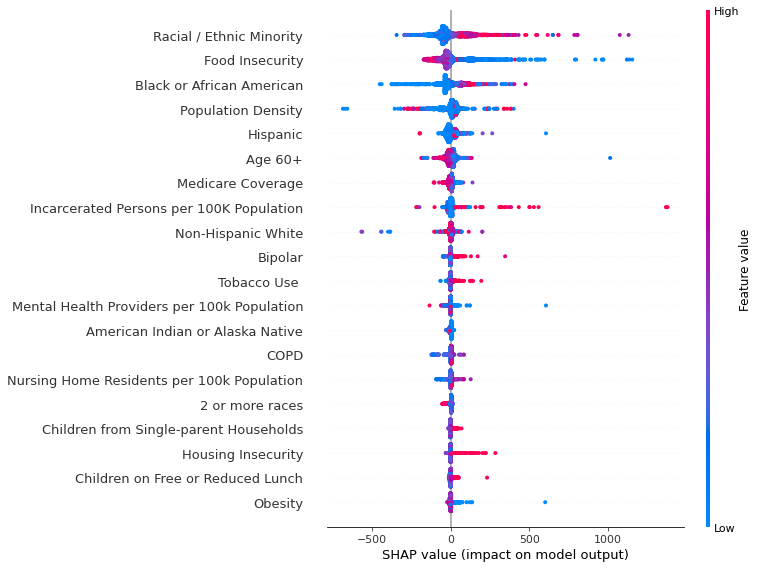

In [18]:
shap.summary_plot(shap_values2, X)

In [19]:
y

0          0.0
1         79.0
2          0.0
3        146.0
4          0.0
         ...  
3133    1156.0
3134     216.0
3135     444.0
3136     354.0
3137     324.0
Name: Cases of Covid 19 Per 100K Population, Length: 3138, dtype: float64

In [20]:
shap_values

array([[-9.40548706e+01, -2.59160936e-01, -1.31347919e+00, ...,
        -3.47353593e-02,  1.45571029e+00,  8.27651882e+00],
       [ 1.66134262e+01, -3.38405102e-01,  7.31466830e-01, ...,
        -2.99925953e-02,  2.05821824e+00, -5.99262848e+01],
       [-1.75284424e+01,  1.11355744e-01, -7.51643896e-01, ...,
        -2.46032313e-01, -3.22090912e+00, -6.41842575e+01],
       ...,
       [-6.57504559e+00,  8.45318846e-03, -1.45878589e+00, ...,
        -3.33823822e-02,  1.84425581e+00,  1.79126740e+02],
       [ 8.94440079e+00,  4.96775191e-03, -5.96402407e-01, ...,
         4.64286596e-01,  2.61664844e+00,  1.64602524e+02],
       [-9.44912148e+00,  6.01953221e-03, -2.24849463e-01, ...,
         5.65874386e+00, -2.34620309e+00, -9.79753647e+01]], dtype=float32)